# March Madness Bracket Predictor

### The objective of this project is to use machine learning models in order to predict the outcomes of March Madness games, then using these predictions to generate a bracket. 

*This project is a work in progress. The initial goal is to get a minimum working example and then progressively improve the results via data exploration, additional models, further hyperparameter tuning, etc.*

## Outline:
1. Problem Definition
2. Data Explaination
3. Evaluation
4. Feature Selection
5. Modeling
6. Results and Summary

## 1. Problem Definition
March Madness is the post season, 64-team bracket for (Men's) NCAA Basketball. The winner of the tournament is deemed the national champion. It is common practice to individually fill out these brackets prior to the start of the first game. The objective of this project is to predict the outcome of a game between two selected teams, this infomation will then be used to generate an entire bracket of predictions.

In [150]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
#Basic imports, they were added as needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb

from feature_vector_prep import matchup_generator

## 2. Data Explanation
This project is currently using data from [RealGM](https://basketball.realgm.com/ncaa/team-stats/2022/Totals/Team_Totals/0). The data contains numerous statistics of each team from the year 02-03 until 21-22 (excluding 19-20 and 20-21 due to COVID irregularities). These statistics include:
* seed = Seed in the NCAA tournament
* wins = Number of wins
* losses = Number of losses
* winp = Win percentage
* cwins = Number of conference wins
* closses = Number of conference losses
* cwinp = Conference win percentage
* pts = Number of points scored
* ptspg = Points per game
* fgm = Number of field goals made
* fga = Number of field goals attempted
* fgp = Field goal percentage
* 3pm = Number of 3 pointers made
* 3pa = Number of 3 pointers attempted
* 3pp = 3 pointer percentage 
* ftm = Number of free throws made
* fta = Number of free throws attempted
* ftp = Free throw percentage
* orb = Number of offensive rebounds
* orbpg = Offensive rebounds per game
* drb = Number of defensive rebounds
* drbpg = Defensive rebounds per game
* reb = Number of rebounds
* rebpg = Rebounds per game
* ast = Number of assists
* astpg = Assists per game
* stl = Number of steals
* stlpg = Steals per game
* blk = Number of blocks
* blkpg = Blocks per game
* tov = Number of turnovers
* tovpg = Turnovers per game
* pf = Number of personal fouls
* pfpg = Personal fouls per game

We will utilize the above attributes to represent each team. For each game, we represent the winner by their stat vector $W = \langle \text{seed, wins, losses,} \dots \text{, pf, pfpg}\rangle$. We represent the loser, $L$ in a similar fashion. Each game is then morphed into two feature vectors: $\langle W - L, 1 \rangle$ and $\langle L - W, 0 \rangle$ to properly account for substraction not being a commutative operation.

In [152]:
# load the feature vector dataframe
df = pd.read_csv("input-vectors.csv")
df = df.dropna()
all_stats = pd.read_csv("all_stats.csv")
all_stats = all_stats.dropna()

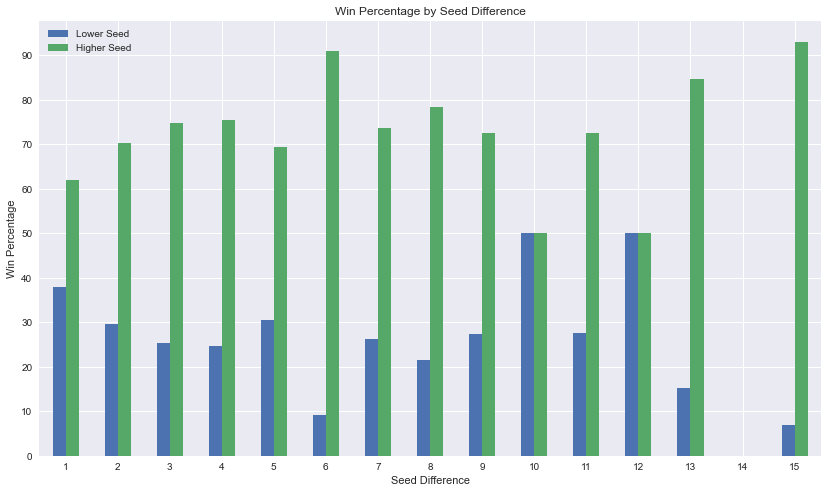

In [153]:
seeds = pd.DataFrame()
seed_df = df[df["result"] == 1]["seed"]
counts = seed_df.value_counts()
for i in range(1, 16):
    total_seeds = counts.get(i, 0) + counts.get(-1*i, 0)
    if total_seeds != 0:
        seeds[i] = [counts.get(-1*i, 0)/total_seeds, counts.get(i, 0)/total_seeds]
    else:
        seeds[i] = [0, 0]
seeds = (seeds.round(3))*100

seeds.T.plot.bar(figsize=(14,8))
plt.title("Win Percentage by Seed Difference")
plt.legend(["Lower Seed", "Higher Seed"])
plt.xlabel("Seed Difference")
plt.xticks(rotation = 0)
plt.ylabel("Win Percentage")
plt.yticks(np.arange(0, 100, 10));

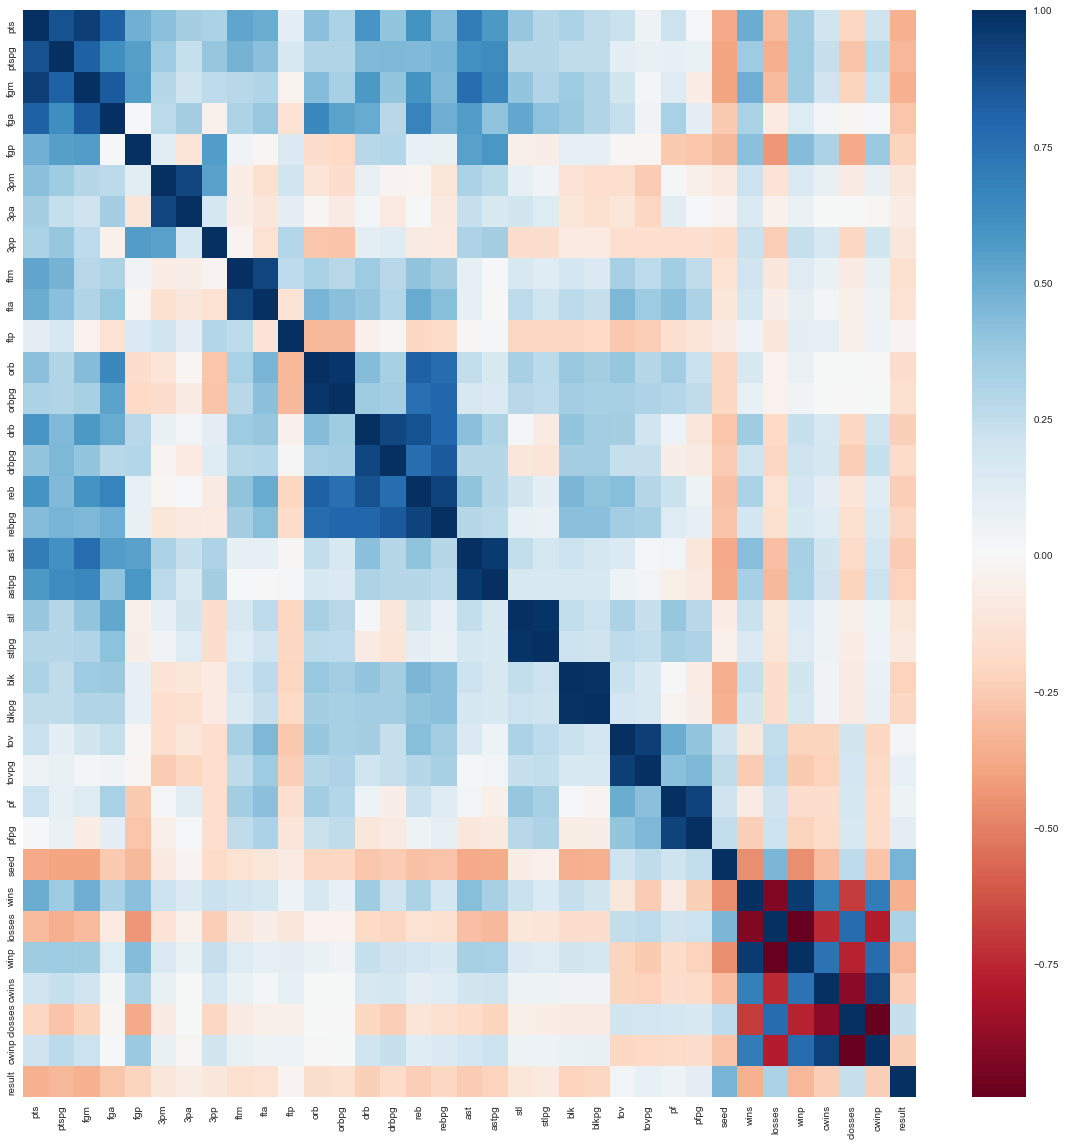

In [154]:
plt.figure(figsize=(20,20))
corr_matrix = df.drop("year", axis=1).corr()
sns.heatmap(corr_matrix, annot=False, cmap="RdBu");

In [155]:
cols_to_drop = ['team0', 'team1',
             'losses', 'winp', 'cwins',
             'closses', 'pts', 'fgm',
             'fga', '3pm', '3pa',
             'ftm', 'fta', 'orb',
             'orbpg', 'drb', 'drbpg',
             'reb', 'ast', 'stl',
             'blk', 'tov', 'pf']

feature_vectors = df.drop(cols_to_drop, axis=1)
feature_vectors

,ptspg,fgp,3pp,ftp,rebpg,astpg,stlpg,blkpg,tovpg,pfpg,seed,wins,cwinp,year,result
0,6.046,0.036,0.010,0.007,3.921,2.886,-0.795,3.370,-1.728,-2.018,-15.0,7.0,0.286,2003.0,0.0
1,-6.046,-0.036,-0.010,-0.007,-3.921,-2.886,0.795,-3.370,1.728,2.018,15.0,-7.0,-0.286,2003.0,1.0
2,15.219,0.002,0.008,0.070,2.479,4.211,3.225,-1.025,2.738,1.034,-1.0,-3.0,-0.230,2003.0,1.0
3,-15.219,-0.002,-0.008,-0.070,-2.479,-4.211,-3.225,1.025,-2.738,-1.034,1.0,3.0,0.230,2003.0,0.0
4,3.824,0.008,-0.029,0.002,1.069,0.918,-0.323,-2.054,2.165,3.914,7.0,4.0,0.250,2003.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261,-2.661,-0.036,-0.006,0.043,1.361,-2.094,-1.047,-1.681,1.432,0.717,6.0,0.0,-0.050,2022.0,0.0
2262,5.952,0.044,-0.004,-0.099,2.335,3.380,0.170,1.905,2.529,0.611,-1.0,2.0,-0.022,2022.0,0.0
2263,-5.952,-0.044,0.004,0.099,-2.335,-3.380,-0.170,-1.905,-2.529,-0.611,1.0,-2.0,0.022,2022.0,1.0
2264,1.073,0.028,-0.007,-0.048,-2.302,0.623,0.988,0.299,0.862,1.489,-7.0,1.0,0.028,2022.0,0.0


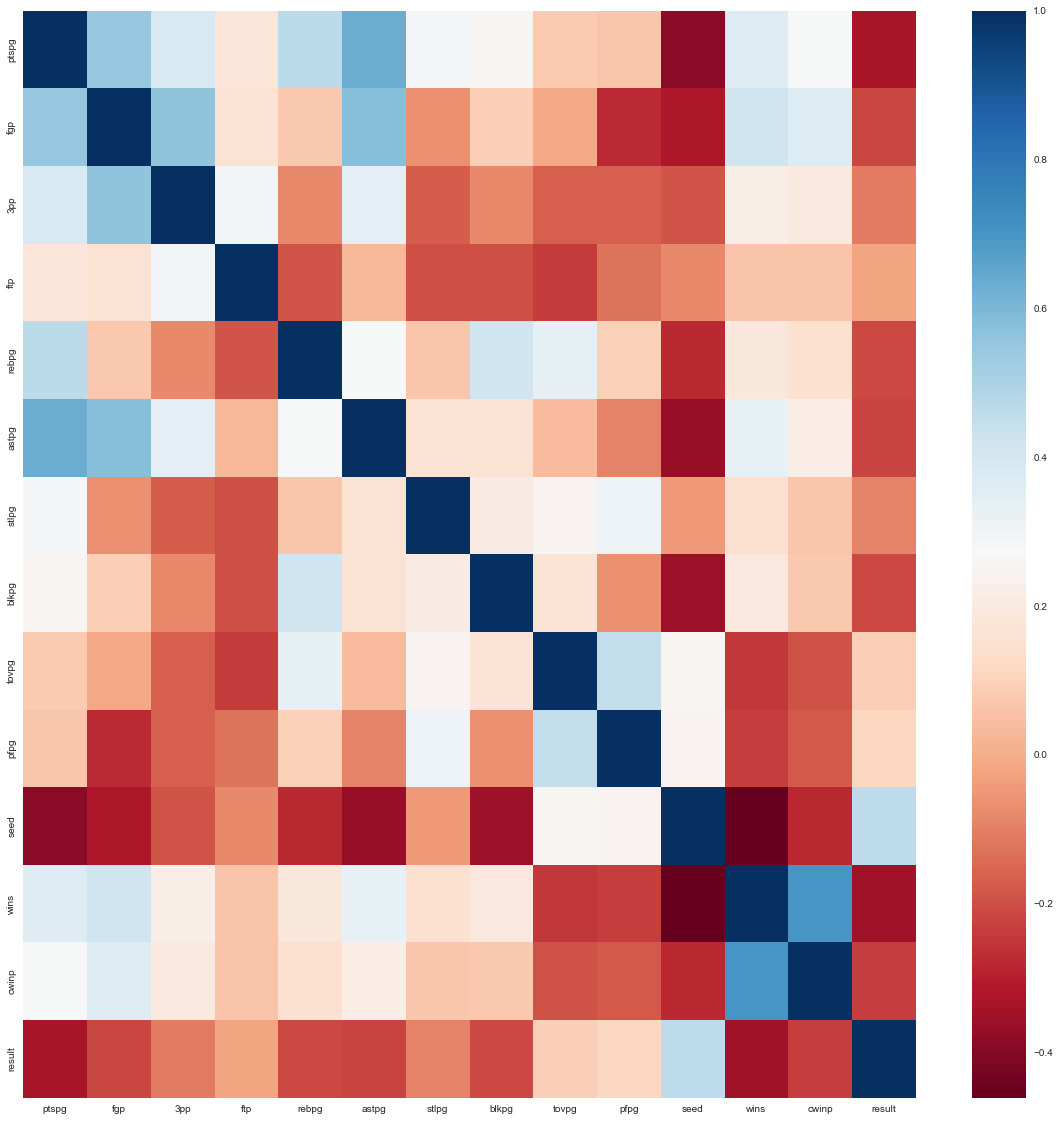

In [156]:
plt.figure(figsize=(20,20))
corr_matrix = feature_vectors.drop("year", axis=1).corr()
sns.heatmap(corr_matrix, annot=False, cmap="RdBu");

In [157]:
df_train = feature_vectors[feature_vectors["year"] < 2022]
df_train = df_train.drop("year", axis=1)
df_train = df_train.sample(frac=1)

In [158]:
X_train = df_train.drop("result", axis=1)
y_train = df_train["result"]

In [159]:
X_train

,ptspg,fgp,3pp,ftp,rebpg,astpg,stlpg,blkpg,tovpg,pfpg,seed,wins,cwinp
1172,2.274,0.009,0.005,-0.016,2.229,0.186,-0.357,0.773,-0.038,0.338,11.0,1.0,-0.028
1111,-1.424,-0.024,0.024,0.016,-0.826,0.193,0.895,-0.963,-1.409,1.288,3.0,-3.0,-0.222
1244,4.317,0.000,0.008,0.011,0.416,2.294,0.686,-0.747,0.147,-0.610,8.0,2.0,-0.105
1491,-0.441,0.008,0.023,0.048,-2.677,2.029,2.206,-1.088,-1.794,-2.029,-7.0,5.0,0.333
1076,11.262,0.044,0.019,0.069,-0.284,4.479,-1.386,-0.481,-4.387,-1.485,-11.0,4.0,0.167
...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,1.129,-0.001,0.020,0.037,1.112,-0.668,-0.908,-3.351,1.547,-1.823,-4.0,-3.0,-0.139
947,-10.382,-0.044,-0.096,-0.037,2.406,-1.719,-2.423,-0.962,-1.955,-3.007,-7.0,-1.0,-0.054
1886,0.336,-0.047,-0.016,-0.033,2.303,2.176,-0.211,-1.220,0.548,1.400,0.0,-5.0,-0.166
1810,3.971,-0.003,-0.025,-0.121,3.794,0.735,3.206,0.911,2.794,5.618,-1.0,1.0,0.000


In [160]:
df_test = feature_vectors[feature_vectors["year"] >= 2023]
df_test = df_test.drop("year", axis=1)
df_test = df_test.sample(frac=1)

In [161]:
X_test = df_test.drop("result", axis=1)
y_test = df_test["result"]

In [168]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
with open("model.pkl", "wb") as f:
    pickle.dump(clf, f)

In [169]:
clf.score(X_test, y_test)

0.6666666666666666

In [170]:
df_bracket = pd.read_csv("brackets/2022-bracket.csv")
df_bracket = df_bracket[df_bracket["round"] == 1]
df_bracket = df_bracket.drop(["winner"], axis=1)
df_bracket
games = []
region_dict = {}
for i, game in df_bracket.iterrows():
    games.append([game.year, game.team0, game.team1, game.region, 1])
all_games = games[:]

region_dict = {}
for game in all_games:
    if len(game) == 3:
        continue
    year, team0, team1, region, round_num = game
    if team0 not in region_dict:
        region_dict[team0] = region
    if team1 not in region_dict:
        region_dict[team1] = region   

temp = []
for i, game in enumerate(games):
    year, team0, team1, region, round_num = game
    matchup = matchup_generator(all_stats, year, team0, team1, winner=None)[0]
    matchup = matchup.drop(cols_to_drop + ["year", "result"])
    prediction = clf.predict(matchup.values[None])[0]
    if prediction == 0:
        temp.append(team0)
    else:
        temp.append(team1)
for j in range(2, 7):
    games = [[year, temp[i], temp[i+1], region_dict[temp[i]] if j < 5 else "none", j] for i in range(0, len(temp), 2)]
    all_games.extend(games[:])
    temp = []
    for i, game in enumerate(games):
        year, team0, team1, region, round_num = game
        if j in [5, 6]:
            region = "none"
        matchup = matchup_generator(all_stats, year, team0, team1, winner=None)[0]
        matchup = matchup.drop(cols_to_drop + ["year", "result"])
        prediction = clf.predict(matchup.values[None])[0]
        if prediction == 0:
            temp.append(team0)
        else:
            temp.append(team1)
matchup = matchup_generator(all_stats, year, team0, team1, winner=None)[0]
matchup = matchup.drop(cols_to_drop + ["year", "result"])
prediction = clf.predict(matchup.values[None])[0]
prediction

1.0

In [172]:
matchup = matchup_generator(all_stats, 2022, "Kansas", "South Dakota State", winner=None)[1]
matchup = matchup.drop(cols_to_drop + ["year", "result"])
prediction = clf.predict_proba(matchup.values[None])[0]
prediction

array([0.30181591, 0.69818409])

In [173]:
all_games

[[2022, 'Gonzaga', 'Georgia State', 'West Regional', 1],
 [2022, 'Boise State', 'Memphis', 'West Regional', 1],
 [2022, 'Connecticut', 'New Mexico State', 'West Regional', 1],
 [2022, 'Arkansas', 'Vermont', 'West Regional', 1],
 [2022, 'Alabama', 'Notre Dame', 'West Regional', 1],
 [2022, 'Texas Tech', 'Montana State', 'West Regional', 1],
 [2022, 'Michigan State', 'Davidson', 'West Regional', 1],
 [2022, 'Duke', 'Cal State Fullerton', 'West Regional', 1],
 [2022, 'Baylor', 'Norfolk State', 'East Regional', 1],
 [2022, 'North Carolina', 'Marquette', 'East Regional', 1],
 [2022, "Saint Mary's", 'Indiana', 'East Regional', 1],
 [2022, 'UCLA', 'Akron', 'East Regional', 1],
 [2022, 'Texas', 'Virginia Tech', 'East Regional', 1],
 [2022, 'Purdue', 'Yale', 'East Regional', 1],
 [2022, 'Murray State', 'San Francisco', 'East Regional', 1],
 [2022, 'Kentucky', "Saint Peter's", 'East Regional', 1],
 [2022, 'Arizona', 'Wright State', 'South Regional', 1],
 [2022, 'Seton Hall', 'Texas Christian', '

In [110]:
region_dict = {}
for game in all_games:
    if len(game) == 3:
        continue
    year, team0, team1, region, round_num = game
    if team0 not in region_dict:
        region_dict[team0] = region
    if team1 not in region_dict:
        region_dict[team1] = region     

{'Gonzaga': 'West Regional',
 'Georgia State': 'West Regional',
 'Boise State': 'West Regional',
 'Memphis': 'West Regional',
 'Connecticut': 'West Regional',
 'New Mexico State': 'West Regional',
 'Arkansas': 'West Regional',
 'Vermont': 'West Regional',
 'Alabama': 'West Regional',
 'Notre Dame': 'West Regional',
 'Texas Tech': 'West Regional',
 'Montana State': 'West Regional',
 'Michigan State': 'West Regional',
 'Davidson': 'West Regional',
 'Duke': 'West Regional',
 'Cal State Fullerton': 'West Regional',
 'Baylor': 'East Regional',
 'Norfolk State': 'East Regional',
 'North Carolina': 'East Regional',
 'Marquette': 'East Regional',
 "Saint Mary's": 'East Regional',
 'Indiana': 'East Regional',
 'UCLA': 'East Regional',
 'Akron': 'East Regional',
 'Texas': 'East Regional',
 'Virginia Tech': 'East Regional',
 'Purdue': 'East Regional',
 'Yale': 'East Regional',
 'Murray State': 'East Regional',
 'San Francisco': 'East Regional',
 'Kentucky': 'East Regional',
 "Saint Peter's": 'Eas

In [105]:
all_games

[[2022, 'Gonzaga', 'Georgia State', 'West Regional', 1],
 [2022, 'Boise State', 'Memphis', 'West Regional', 1],
 [2022, 'Connecticut', 'New Mexico State', 'West Regional', 1],
 [2022, 'Arkansas', 'Vermont', 'West Regional', 1],
 [2022, 'Alabama', 'Notre Dame', 'West Regional', 1],
 [2022, 'Texas Tech', 'Montana State', 'West Regional', 1],
 [2022, 'Michigan State', 'Davidson', 'West Regional', 1],
 [2022, 'Duke', 'Cal State Fullerton', 'West Regional', 1],
 [2022, 'Baylor', 'Norfolk State', 'East Regional', 1],
 [2022, 'North Carolina', 'Marquette', 'East Regional', 1],
 [2022, "Saint Mary's", 'Indiana', 'East Regional', 1],
 [2022, 'UCLA', 'Akron', 'East Regional', 1],
 [2022, 'Texas', 'Virginia Tech', 'East Regional', 1],
 [2022, 'Purdue', 'Yale', 'East Regional', 1],
 [2022, 'Murray State', 'San Francisco', 'East Regional', 1],
 [2022, 'Kentucky', "Saint Peter's", 'East Regional', 1],
 [2022, 'Arizona', 'Wright State', 'South Regional', 1],
 [2022, 'Seton Hall', 'Texas Christian', '

In [72]:
matchup

ptspg    4.352
fgp       0.02
3pp      0.027
ftp       0.06
rebpg   -0.823
astpg    0.177
stlpg   -1.764
blkpg    0.323
tovpg   -1.118
pfpg    -3.735
seed      -3.0
wins      -4.0
cwinp   -0.033
dtype: object

In [90]:
a = matchup_generator(all_stats, 2022, "Kansas", "Duke")
blarg = pd.DataFrame(a)
display(blarg)
b = blarg.drop(cols_to_drop + ["year", "result"], axis=1)
display(b)
clf.predict_proba(b)

,pts,ptspg,fgm,fga,fgp,3pm,3pa,3pp,ftm,fta,...,wins,losses,winp,cwins,closses,cwinp,year,team0,team1,result
0,-54.0,-1.588,-35.0,-39.0,-0.008,-35.0,-71.0,-0.013,51.0,74.0,...,1.0,-1.0,0.03,-2.0,0.0,-0.022,2022.0,Kansas,Duke,NaN
1,54.0,1.588,35.0,39.0,0.008,35.0,71.0,0.013,-51.0,-74.0,...,-1.0,1.0,-0.03,2.0,0.0,0.022,2022.0,Duke,Kansas,NaN


,ptspg,fgp,3pp,ftp,rebpg,astpg,stlpg,blkpg,tovpg,pfpg,seed,wins,cwinp
0,-1.588,-0.008,-0.013,-0.005,-0.941,-1.471,-0.059,-1.382,2.294,2.206,-1.0,1.0,-0.022
1,1.588,0.008,0.013,0.005,0.941,1.471,0.059,1.382,-2.294,-2.206,1.0,-1.0,0.022


array([[0.87786741, 0.12213259],
       [0.11714462, 0.88285538]])

In [25]:
games

[[2022, 'Gonzaga', 'Georgia State'],
 [2022, 'Boise State', 'Memphis'],
 [2022, 'Connecticut', 'New Mexico State'],
 [2022, 'Arkansas', 'Vermont'],
 [2022, 'Alabama', 'Notre Dame'],
 [2022, 'Texas Tech', 'Montana State'],
 [2022, 'Michigan State', 'Davidson'],
 [2022, 'Duke', 'Cal State Fullerton'],
 [2022, 'Baylor', 'Norfolk State'],
 [2022, 'North Carolina', 'Marquette'],
 [2022, "Saint Mary's", 'Indiana'],
 [2022, 'UCLA', 'Akron'],
 [2022, 'Texas', 'Virginia Tech'],
 [2022, 'Purdue', 'Yale'],
 [2022, 'Murray State', 'San Francisco'],
 [2022, 'Kentucky', "Saint Peter's"],
 [2022, 'Arizona', 'Wright State'],
 [2022, 'Seton Hall', 'Texas Christian'],
 [2022, 'Houston', 'UAB'],
 [2022, 'Illinois', 'Chattanooga'],
 [2022, 'Colorado State', 'Michigan'],
 [2022, 'Tennessee', 'Longwood'],
 [2022, 'Ohio State', 'Loyola (IL)'],
 [2022, 'Villanova', 'Delaware'],
 [2022, 'Kansas', 'Texas Southern'],
 [2022, 'San Diego State', 'Creighton'],
 [2022, 'Iowa', 'Richmond'],
 [2022, 'Providence', 'Sou

In [91]:
a = pd.read_csv(f"brackets/{year}-bracket.csv")
a

,year,team0,team1,region,round,winner
0,2022,Wyoming,Indiana,none,0,1
1,2022,Texas Southern,Texas A&M-CC,none,0,0
2,2022,Rutgers,Notre Dame,none,0,1
3,2022,Wright State,Bryant,none,0,0
4,2022,Gonzaga,Georgia State,West Regional,1,0
...,...,...,...,...,...,...
62,2022,Miami (FL),Iowa State,Midwest Regional,3,0
63,2022,Kansas,Miami (FL),Midwest Regional,4,0
64,2022,Duke,North Carolina,none,5,1
65,2022,Kansas,Villanova,none,5,0


In [ ]:
h

In [22]:
blarg.drop(cols_to_drop, axis=1)

NameError: name 'blarg' is not defined

In [50]:
blarg

,pts,ptspg,fgm,fga,fgp,3pm,3pa,3pp,ftm,fta,...,wins,losses,winp,cwins,closses,cwinp,year,team0,team1,result
0,74.0,2.242,24.0,-49.0,0.024,20.0,59.0,-0.001,6.0,-55.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,Miami (FL),USC,0
1,-74.0,-2.242,-24.0,49.0,-0.024,-20.0,-59.0,0.001,-6.0,55.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,USC,Miami (FL),1


In [51]:

blarg

,pts,ptspg,fgm,fga,fgp,3pm,3pa,3pp,ftm,fta,...,wins,losses,winp,cwins,closses,cwinp,year,team0,team1,result
0,74.0,2.242,24.0,-49.0,0.024,20.0,59.0,-0.001,6.0,-55.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,Miami (FL),USC,0
1,-74.0,-2.242,-24.0,49.0,-0.024,-20.0,-59.0,0.001,-6.0,55.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,USC,Miami (FL),1


In [64]:
a = matchup_generator(all_stats, 2022, "Miami (FL)", "USC", winner=0)
blarg = pd.DataFrame(a)
display(blarg)
b = blarg.drop(cols_to_drop + ["year", "result"], axis=1)
display(b)
clf.predict_proba(b)

,pts,ptspg,fgm,fga,fgp,3pm,3pa,3pp,ftm,fta,...,wins,losses,winp,cwins,closses,cwinp,year,team0,team1,result
0,74.0,2.242,24.0,-49.0,0.024,20.0,59.0,-0.001,6.0,-55.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,Miami (FL),USC,0
1,-74.0,-2.242,-24.0,49.0,-0.024,-20.0,-59.0,0.001,-6.0,55.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,USC,Miami (FL),1


,ptspg,fgp,3pp,ftp,rebpg,astpg,stlpg,blkpg,tovpg,pfpg,seed,wins,cwinp
0,2.242,0.024,-0.001,0.077,-9.969,-0.152,3.606,-1.546,-2.424,-0.667,3.0,0.0,0.0
1,-2.242,-0.024,0.001,-0.077,9.969,0.152,-3.606,1.546,2.424,0.667,-3.0,0.0,0.0


array([[0.48294447, 0.51705553],
       [0.51705553, 0.48294447]])

In [53]:
y_preds = clf.predict(X_test)
y_preds

array([1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
       1., 1., 0., 0., 1., 1., 1.])

In [ ]:
df_test["preds"] = y_preds
a = df_test[df_test["preds"] != df_test["result"]].index

In [ ]:
df.loc[a].head(50)

In [ ]:
blah = pd.read_csv(f"brackets/2022-bracket.csv")
b = blah[blah["year"] == 2022]
b = blah[blah["round"] == 1.0]
b = b[["year", "team0", "team1", "region"]]
b
b.to_csv("test-input.csv", index=False)

In [ ]:
r = results.iloc[::2]
r.head(50)

In [ ]:
results = df[df["year"] == 2022]
results = results[["team0", "team1", "result"]]
results["pred"] = y_preds
results[results["result"] != results["pred"]]

In [ ]:
df_test

In [ ]:
X_test.head()

In [ ]:
y_test.head()

In [ ]:
test = X_test
test["result"] = y_test
test["pred"] = y_preds

In [ ]:
test

In [ ]:
y_preds != y_test

In [ ]:
mismatch = []
for pred, label in zip(y_preds, y_test):
    if pred != label:
        mismatch.append(y_preds[pred].index)
        
mismatch

In [ ]:
a = (y_preds != y_test)
a

In [ ]:
a[a]

In [ ]:
a = list(a[a].index)
a = a[::2]

In [ ]:
df

In [ ]:
df.loc[a]